![WoW logo](datasets/logo.png)


# What is World of Wacraft?
According to Wikipedia:

> World of Warcraft (WoW) is a massively multiplayer online role-playing game (MMORPG) released in 2004 by Blizzard Entertainment. It is the fourth released game set in the Warcraft fantasy universe. World of Warcraft takes place within the Warcraft world of Azeroth, approximately four years after the events at the conclusion of Blizzard's previous Warcraft release, Warcraft III: The Frozen Throne. The game was announced in 2001, and was released for the 10th anniversary of the Warcraft franchise on November 23, 2004. Since launch, World of Warcraft has had eight major expansion packs produced for it: The Burning Crusade, Wrath of the Lich King, Cataclysm, Mists of Pandaria, Warlords of Draenor, Legion, Battle for Azeroth and Shadowlands.

> World of Warcraft was the world's most popular MMORPG by player count of nearly 10 million in 2009. The game had a total of over a hundred million registered accounts by 2014. By 2017, the game had grossed over $9.23 billion in revenue, making it one of the highest-grossing video game franchises of all time. At BlizzCon 2017, a vanilla version of the game titled World of Warcraft Classic was announced, which planned to provide a way to experience the base game before any of its expansions launched. It was released in August 2019.

### Why is it worth investigating?

The game World of Warcraft has already been a gold mine when it comes to scientific work (see [google scholar](https://scholar.google.com/scholar?hl=pl&as_sdt=0,5&q=world+of+warcraft)). From social studies to finance, the world created by Blizzard has given many information about how players behave with their created characters, modelling how they act in real life. In this notebook, I will explore the auction house prices driven by demand over a few months for raid supplies.

### What is the meaning of all those strange words?

World of Wacraft as any other game has specific terminology for items that are present in the world. Here is a summary of the specific items and words that will be used while researching this notebook.

- **PvE** - Player versus Environment, gameplay that focuses on fighting computer generated enemies,
- **PvP** - Player versus Player, gameplay that focuses on fighting other players,
- **Party** - A group of 2-5 players, created for participating in PvE or PvP scenarios,
- **Raid Group** - A group of 6-40 players divided in groups of 5, created for participating in PvE or PvP scenarios,
- **Raid** - An instanced dungeon, with several bosses that, proves a challenge for a raid group,
- **Flask** - One hour character stats buff that persists through death,
- **Potion** - A short boost to stats, that increases damage, survivability etc,
- **Food** - Long character stats buff that dissapears on death,
- **Feast** - A table that provides food buffs, but can be used by multiple people in a group.
- **Money** - The amount of money you have. It's divided into gold, silver and copper:
   - 100 copper = 1 silver,
   - 100 silver = 1 gold.
- **Auction House (AH)** - Place where people sell their goods in-game.  

# Loading in the data

In this section we will load the data from the csv file and set a couple of things:

- Select `;` separator and select `id` as index,
- `item_name` and `item_subclass` as categorical data,
- Parse dates for `created_at` - this is the time the data was gathered from the AH,

In [1]:
# Import libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

In [2]:
# Read the data and preview sample rows
wow = pd.read_csv(
    'datasets/tsm_data.csv',
    sep=';',
    index_col='id',
    parse_dates=['created_at'],
    dtype={
        'item_name': 'category',
        'item_subclass': 'category',
    },
)
display(wow.sample(5, random_state=42))
wow.info()

,item_name,item_subclass,item_vendor_buy,item_vendor_sell,item_market_value,item_min_buyout,item_quantity,item_num_auctions,created_at
id,,,,,,,,,
38240,Greater Flask of the Vast Horizon,Flask,10000,2500,6730521,6899900,1821,37,2020-03-13 19:54:26
9850,Potion of Wild Mending,Potion,10000,2500,759781,739548,449,39,2019-12-08 15:30:40
2819,Potion of Unbridled Fury,Potion,10000,2500,1026773,1000200,7629,532,2019-11-22 23:03:07
30800,Superior Battle Potion of Agility,Potion,10000,2500,1192344,1399800,2100,30,2020-02-26 05:56:37
43488,Fragrant Kakavia,Food & Drink,25000,1250,54392,45800,2005,10,2020-03-25 14:31:04


<class 'pandas.core.frame.DataFrame'>
Int64Index: 44859 entries, 305 to 45163
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   item_name          44859 non-null  category      
 1   item_subclass      44859 non-null  category      
 2   item_vendor_buy    44859 non-null  int64         
 3   item_vendor_sell   44859 non-null  int64         
 4   item_market_value  44859 non-null  int64         
 5   item_min_buyout    44859 non-null  int64         
 6   item_quantity      44859 non-null  int64         
 7   item_num_auctions  44859 non-null  int64         
 8   created_at         44859 non-null  datetime64[ns]
dtypes: category(2), datetime64[ns](1), int64(6)
memory usage: 2.8 MB


# Data Cleaning

The good thing is that we don't have any null values. In this section we will do a couple of things tho:

- Remove `item_vendor_buy` and `item_vendor_sell` columns as they don't carry any relevant information,
- Remove `item_market_value` as it's TSM related information,
- Filter out items with `0` auctions at a specified time,
- Remove outlier potions that someone put for horrendal prices (they would never sell anyway),
- Update values to be in gold instead of copper, for readability (and noone really uses copper as their base),
- Add "days since new raid" column to see if it influences the prices.

In [3]:
# Filter out empty rows
wow = wow[wow['item_num_auctions'] > 0]

# Remove irrelevant columns
wow.drop(
    columns=[
        'item_vendor_buy',
        'item_vendor_sell',
        'item_market_value',
    ],
    inplace=True
)

# Update copper to gold
wow['item_min_buyout'] = wow['item_min_buyout'] / 10000

# Remove outliers
bad_ids = [1884, 1903, 1922, 1941, 1960]
wow.drop(index=bad_ids, inplace=True)

# Add days since raid release
ETERNAL_PALACE_RELEASE = pd.Timestamp('2019.07.10')
NYALOTHA_RELEASE = pd.Timestamp('2020.01.21')
def calculate_days_since_new_raid(date):
    ep_release = ETERNAL_PALACE_RELEASE
    ny_release = NYALOTHA_RELEASE
    if date < ny_release:
        return (date - ep_release).days
    else:
        return (date - ny_release).days

wow['days_after_new_raid'] = wow.apply(
    lambda row: calculate_days_since_new_raid(row['created_at']),
    axis=1,
)

In [4]:
# Preview dataframe after cleaning
display(wow.sample(5, random_state=42))
wow.info()

,item_name,item_subclass,item_min_buyout,item_quantity,item_num_auctions,created_at,days_after_new_raid
id,,,,,,,
38797,Bil'Tong,Food & Drink,25.00,14014,31,2020-03-15 01:28:42,54
12556,Fragrant Kakavia,Food & Drink,4.00,713,47,2019-12-15 12:23:12,158
13099,Potion of Wild Mending,Potion,44.50,517,56,2019-12-16 17:51:39,159
3057,Baked Port Tato,Food & Drink,10.00,11742,637,2019-11-23 11:04:26,136
36192,Fragrant Kakavia,Food & Drink,4.58,6523,23,2020-03-09 05:39:55,48


<class 'pandas.core.frame.DataFrame'>
Int64Index: 44702 entries, 305 to 45163
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   item_name            44702 non-null  category      
 1   item_subclass        44702 non-null  category      
 2   item_min_buyout      44702 non-null  float64       
 3   item_quantity        44702 non-null  int64         
 4   item_num_auctions    44702 non-null  int64         
 5   created_at           44702 non-null  datetime64[ns]
 6   days_after_new_raid  44702 non-null  int64         
dtypes: category(2), datetime64[ns](1), float64(1), int64(3)
memory usage: 2.1 MB


# Data Analysis
Our dataset has 44702 non-null entries. The name of the item and its subclass are categorical values. The `item_min_buyout` is the value that people usually buy items at (with the buyout option, rather than actually doing auctions). The `item_quantity` is the number of items, while `item_num_auctions` is the number of auctions those items belong to (one auction can have multiple items).

We can preview the statistical numerics below. Due to the fact that we are comparing items of various subclasses, the minimum and maximum values will be quite different, we will deal with this when we go deeper into the analysis, but already we can see how consumables place on the auction house for the selected time period.

In [5]:
# Preview the dataset statistical numerics
wow.describe()

,item_min_buyout,item_quantity,item_num_auctions,days_after_new_raid
count,44702.000000,44702.000000,44702.000000,44702.000000
mean,251.548674,7728.937989,170.392846,102.935998
std,453.994244,19342.280116,249.134527,63.154147
min,0.010000,1.000000,1.000000,0.000000
25%,29.990000,1107.000000,33.000000,46.000000
50%,90.299300,2807.000000,74.000000,133.000000
75%,299.000000,7385.750000,220.000000,159.000000
max,4999.180000,607024.000000,4337.000000,194.000000


The dataset starts at `2019.11.17 00:03` and the last entry is at `2020.03.29 15:27` with 4374 unique entries. Over the course of the months, the data was gathered roughly each hour, unless the server went down (2 times) or the TSM API was unavailable.

In [6]:
# Preview the timeseries of the dataset
wow['created_at'].describe()

count                   44702
unique                   4373
top       2019-12-19 15:44:36
freq                       19
first     2019-11-17 00:03:12
last      2020-03-29 15:27:13
Name: created_at, dtype: object

We can preview the items and subclasses next. There is a total of 19 unique items divided into 3 subclasses: Potion, Flask and Food & Drink. During the gathering of data, I focused on getting items useful for raiding at that time. Below you can preview the table describing which item goes into what subclass.

In [7]:
# How many different items and subclasses are there?
unique_items = wow['item_name'].unique().tolist()
unique_subclass = wow['item_subclass'].unique().tolist()
f'There are {len(unique_items)} unique items in {len(unique_subclass)} subclasses.'

'There are 19 unique items in 3 subclasses.'

In [8]:
# List the items and their classes
wow.drop_duplicates(subset=['item_name'])[['item_name', 'item_subclass']].set_index('item_subclass')

,item_name
item_subclass,
Potion,Superior Battle Potion of Agility
Potion,Superior Battle Potion of Intellect
Potion,Superior Battle Potion of Stamina
Potion,Superior Battle Potion of Strength
Potion,Potion of Focused Resolve
Potion,Potion of Empowered Proximity
Potion,Potion of Unbridled Fury
Potion,Potion of Wild Mending
Potion,Abyssal Healing Potion


As correlations go, we can see a few interesting connections:

- The `item_min_buyout` isn't really dependant on the quantity of the item or the number of auctions,
- The `item_min_buyout` has a negative correlation with the number of days since last raid came out, meaning that the longer it is from the release, the prices go down,
- The `item_quantity` has a quite high positive correlation with `item_num_auction`. That doesn't give us anything useful, as the data duplicates itself (the more auctions you have, the more items will be on the ah generally).
- Interestingly `days_after_new_raid` has a positive correlation with `item_num_auctions`. This can happen from a couple of reasons: either more people can craft the recepies, the number of items that didn't sell increased over time, or less people buy the items in general... or all at the same time.

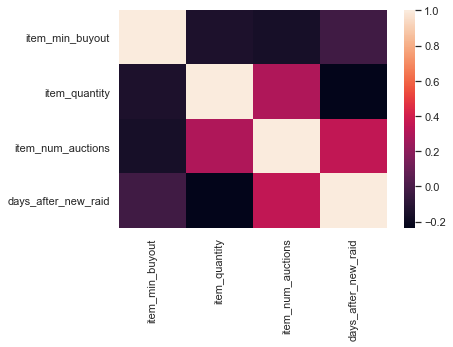

In [9]:
# Preview correlations
sns.heatmap(wow.corr())

We will take out the `Famine Evaluator And Snack Table` to analyze it separately from other food items. This is because the prices for one feast are vastly higher than normal food items, so the plots would look horrible. We will also groupby the items by day and subcategory, taking the mean, to see what generally happens with the prices for selected subcategories.

As we can see in the two plots below, the prices vary over time. Interestingly we can see a big increase, then a huge drop and again a big increase around the release of Ny'alotha Raid. This is due how the playerbase behaves around new raid releases. Players come back to the game before the raid, just to get bored of content (again decreasing), to the point where hardcore players buy out items to progress through the new raid. The prices usually increase over the first couple of weeks, to drop slowly to the next raid release.

In [10]:
# Exclude feast from other due to big single item value
wow_feast = wow[wow['item_name'] == 'Famine Evaluator And Snack Table']
wow_other = wow[wow['item_name'] != 'Famine Evaluator And Snack Table']

In [11]:
# Check mean prices over the period for subclasses
wow_daily = wow_other.groupby([wow_other['created_at'].dt.date, 'item_subclass']).mean().reset_index()
wow_daily_feast = wow_feast.groupby([wow_feast['created_at'].dt.date]).mean().reset_index()

display('Mean values based on subclass:')
display(wow_daily.head())
display('Mean feast values based on subclass:')
display(wow_daily_feast.head())

'Mean values based on subclass:'

,created_at,item_subclass,item_min_buyout,item_quantity,item_num_auctions,days_after_new_raid
0,2019-11-17,Flask,366.485790,2188.900000,321.050000,130.0
1,2019-11-17,Food & Drink,8.467825,6298.066667,351.133333,130.0
2,2019-11-17,Potion,74.318714,2929.777778,201.644444,130.0
3,2019-11-18,Flask,354.321932,1778.531250,250.114583,131.0
4,2019-11-18,Food & Drink,8.458718,5806.416667,346.625000,131.0


'Mean feast values based on subclass:'

,created_at,item_min_buyout,item_quantity,item_num_auctions,days_after_new_raid
0,2019-11-17,1819.586573,269.733333,52.600000,130.0
1,2019-11-18,1915.288267,174.166667,28.750000,131.0
2,2019-11-19,2062.753635,79.869565,20.565217,132.0
3,2019-11-20,2101.455333,106.166667,39.750000,133.0
4,2019-11-21,2580.546729,71.708333,21.875000,134.0


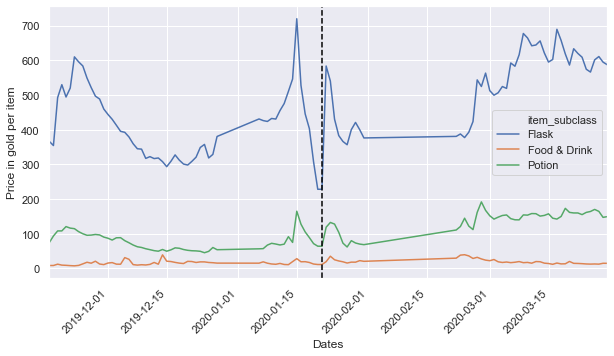

In [12]:
# Daily mean prices per item subclass
plt.figure(figsize=(10,5))
ax = sns.lineplot(
    x='created_at',
    y='item_min_buyout',
    hue='item_subclass',
    data=wow_daily
)
ax.set_xlim(wow_daily['created_at'].min(), wow_daily['created_at'].max())
ax.set_xlabel('Dates')
ax.set_ylabel('Price in gold per item')
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
)
plt.axvline(NYALOTHA_RELEASE, color='black', linestyle='--', label='Ny\'alotha')
plt.show()

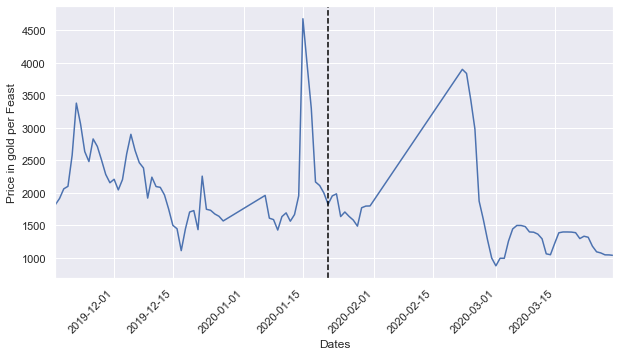

In [13]:
# The same but for Feasts
plt.figure(figsize=(10,5))
ax = sns.lineplot(
    x='created_at',
    y='item_min_buyout',
    data=wow_daily_feast
)
ax.set_xlim(wow_daily_feast['created_at'].min(), wow_daily_feast['created_at'].max())
ax.set_xlabel('Dates')
ax.set_ylabel('Price in gold per Feast')
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
),
plt.axvline(NYALOTHA_RELEASE, color='black', linestyle='--', label='Ny\'alotha')
plt.show()

An interesting thing to check was how the numbers change during the weekday. Usually guilds go to raids on selected days of a week. Popular days are wednesday, thursday and sunday. As we can see, the prices drop closer to the reset (which happens on wednesday), to jump up on wednesday and thursday, to go slowly down again. This was expected behavior. The only interesting thing is that feasts are usually bought on thursday.

Hourly prices were also checked, but didn't provide any interesting results.

In [14]:
# Check mean prices for days of week
wow_weekday = wow_other.groupby([wow_other['created_at'].dt.dayofweek, 'item_subclass']).mean().reset_index()
wow_weekday_feast = wow_feast.groupby(wow_feast['created_at'].dt.dayofweek).mean().reset_index()

display('Mean values based on subclass:')
display(wow_weekday.head())
display('Mean feast values based on subclass:')
display(wow_weekday_feast.head())

'Mean values based on subclass:'

,created_at,item_subclass,item_min_buyout,item_quantity,item_num_auctions,days_after_new_raid
0,0,Flask,443.805849,4575.356214,167.212428,111.239884
1,0,Food & Drink,16.582373,15125.650867,215.187283,111.239884
2,0,Potion,97.761568,14321.685934,210.751766,111.239884
3,1,Flask,458.836880,2592.485795,175.325994,101.343750
4,1,Food & Drink,17.221317,10804.410227,208.827841,101.343750


'Mean feast values based on subclass:'

,created_at,item_min_buyout,item_quantity,item_num_auctions,days_after_new_raid
0,0,1815.842046,631.098266,44.583815,111.239884
1,1,1806.798160,568.008523,41.593750,101.343750
2,2,1909.677261,404.769697,36.142424,98.324242
3,3,1952.869326,467.685714,40.171429,101.937143
4,4,1847.526357,468.354839,40.009677,99.364516


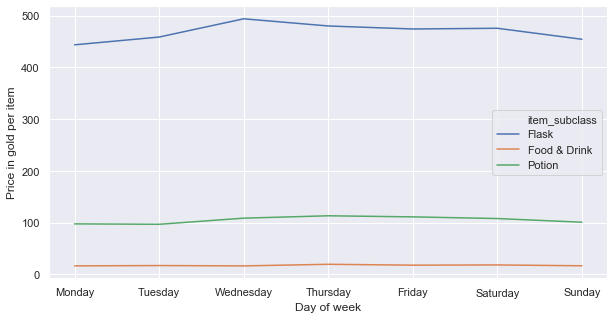

In [15]:
# Weekday mean prices per item subclass
plt.figure(figsize=(10,5))
days = ['', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
ax = sns.lineplot(
    x='created_at',
    y='item_min_buyout',
    hue='item_subclass',
    data=wow_weekday,
)
ax.set_xlabel('Day of week')
ax.set_ylabel('Price in gold per item')
ax.set(xticklabels=days)
plt.show()

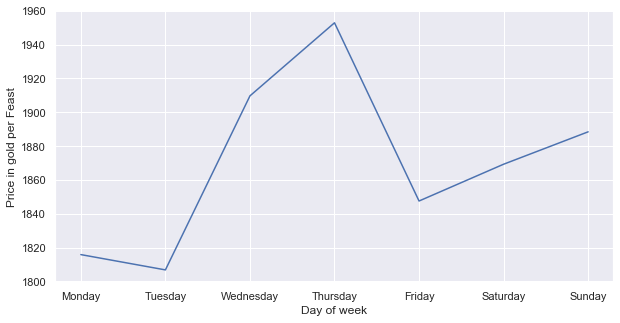

In [16]:
# Weekday Feast mean prices per item subclass
plt.figure(figsize=(10,5))
days = ['', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
ax = sns.lineplot(
    x='created_at',
    y='item_min_buyout',
    data=wow_weekday_feast,
)
ax.set_xlabel('Day of week')
ax.set_ylabel('Price in gold per Feast')
ax.set(xticklabels=days)
plt.show()

# Auction House Prediction

Under construction.